<a href="https://colab.research.google.com/github/yeonghun00/stock_public/blob/main/portfolio%20optimization_asset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install PyPortfolioOpt
!pip install yfinance

In [2]:
import yfinance as yf
import pandas as pd
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# ['QQQ', 'AGG', 'BTC', 'GLD']
# Read in price data
df = yf.download(['QQQ', 'AGG', 'VNQ', 'GLD', 'FGD'],start = '2005-02-01')['Adj Close']

# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
ef.save_weights_to_file("weights.csv")  # saves to file
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

[*********************100%***********************]  5 of 5 completed
OrderedDict([('AGG', 0.63955), ('FGD', 0.0), ('GLD', 0.12059), ('QQQ', 0.23986), ('VNQ', 0.0)])
Expected annual return: 7.4%
Annual volatility: 6.4%
Sharpe Ratio: 0.84


(0.07405418604465931, 0.06424052074839949, 0.8414344313360198)

In [3]:
weights = cleaned_weights

In [4]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices


latest_prices = get_latest_prices(df)

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da.greedy_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Discrete allocation: {'AGG': 54, 'QQQ': 6, 'GLD': 7}
Funds remaining: $353.01


/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


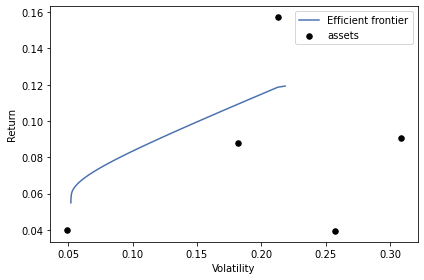

In [5]:
import pypfopt.plotting as plotting
import numpy as np
import matplotlib.pyplot as plt

ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
ef.add_constraint(lambda w: w[0] >= 0.2)
ef.add_constraint(lambda w: w[2] == 0.15)
ef.add_constraint(lambda w: w[3] + w[4] <= 0.10)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.show()

/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


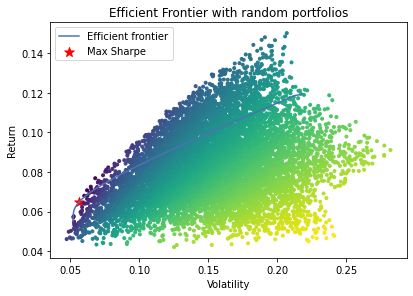

<Figure size 1440x1440 with 0 Axes>

In [6]:
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt(np.diag(w @ S @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.figure(figsize=(20,20))
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()